In [1]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests
import tqdm
from time import sleep


In [9]:
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder

In [3]:
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name

In [4]:
def get_data_pbp(game_id):
    game_url = f"https://data.nba.com/data/10s/v2015/json/mobile_teams/nba/2019/scores/pbp/{game_id}_full_pbp.json"
    resp = requests.get(game_url)
    data = resp.json()
    pl_data = data['g']['pd']
    data_dfs = []
    for i in range(4):
        data_pbp_df = pd.DataFrame.from_records(pl_data[i]['pla'])
        data_dfs.append(data_pbp_df)
    return pd.concat(data_dfs, ignore_index=True)

In [5]:
def get_pbp_dfs(player_id, team_id):
    game_finder = LeagueGameFinder(player_or_team_abbreviation='P', season_nullable='2019-20', player_id_nullable=player_id, team_id_nullable=team_id, season_type_nullable='Regular Season')
    games = game_finder.get_data_frames()[0]
    data_frames = []
    stats_dfs = []
    data_dfs = []
    for game_id in tqdm.tqdm(games.GAME_ID.unique().tolist()):
        stats_pbp = PlayByPlayV2(game_id=game_id)
        stats_pbp_df = stats_pbp.get_data_frames()[0]
        data_pbp = get_data_pbp(game_id=game_id)
        data_pbp.loc[:, 'GAME_ID'] = game_id
        merged = pd.merge(left=stats_pbp_df, right=data_pbp, left_on=('EVENTNUM'), right_on=('evt'), suffixes=('_stats', '_data'))
        stats_dfs.append(stats_pbp_df)
        data_dfs.append(data_pbp)
        data_frames.append(merged)
        sleep(0.5)
    return pd.concat(data_frames, ignore_index=True), pd.concat(stats_dfs, ignore_index=True), pd.concat(data_dfs, ignore_index=True)

In [6]:
player_id = find_players_by_full_name('Anthony Davis')[0]['id']

In [7]:
team_id = "1610612747"

In [10]:
pbp_df, stats_dfs, data_dfs = get_pbp_dfs(player_id=player_id, team_id=team_id)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [02:11<00:00,  2.39s/it]


In [11]:
pbp_df.locX = -pbp_df.locX

## Block Chart

In [12]:
import random
from matplotlib.patches import Circle, Rectangle, Arc

# Amazing function by Bradley Fay for plotting the nba court
# source: https://github.com/bradleyfay/py-Goldsberry/blob/master/docs/Visualizing%20NBA%20Shots%20with%20py-Goldsberry.ipynb
def draw_court(ax=None, color='black', lw=2, background_color="#EBEBE8", outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False, zorder=0)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False, zorder=0)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False, zorder=0)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed', zorder=0)
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color, zorder=0)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 138, linewidth=lw,
                               color=color, zorder=0)
    corner_three_b = Rectangle((220, -47.5), 0, 138, linewidth=lw, color=color, zorder=0)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22.13, theta2=157.87, linewidth=lw,
                    color=color, zorder=0)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=0)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=0)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]
    
    # Draw the half court line, baseline and side out bound lines
    outer_lines = Rectangle((-249, -48), 498, 470, linewidth=lw,
                            color=color, fill=None)
    court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [32]:
def plot_raw_shotchart(data_frame, title, mode="dark", assist_df=None, image_name=None):
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize=(12, 12))
    green = '#45B056'
    red = '#B04556'
    
    # ('Mid-Range', 'Right Side Center(RC)', '16-24 ft.')
    bball_gray = '#312f30'
    bball_white = '#dddee0'
    bball_orange = '#f87c24'
    bball_light_orange = '#fbaf7b'

    paths = ax.scatter(
        x=data_frame.locX,
        y=data_frame.locY,
        marker='o',
        c=bball_white,
        s=180,
        alpha=0.8,
        lw=1,
        edgecolors='black',
        label='BLOCKED SHOT'
    )
    
    if mode == 'dark':
        background_color="#363F48"
        font_color="#E8E8FF"
    else:
        background_color="#EBEBE8"
        font_color = "#454545"

    
    # Changing court color
    #ax.set_facecolor('#FFFAFA')
    
    ax.set_facecolor(bball_gray)
    fig.set_facecolor(bball_gray)
    ax.set_frame_on(False)
    
    # Legend
    legend = ax.legend()
    frame = legend.get_frame()
    frame.set_facecolor(bball_gray)
    frame.set_linewidth(2)
    frame.set_edgecolor(bball_light_orange)
    for text in legend.get_texts():
        text.set_color(bball_white)

    # Removing ticks
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.grid(False)
    
    # Title
    ax.set_title(title, size=20, color=bball_light_orange)
    
    # Drawing court
    draw_court(ax=ax,outer_lines=True, lw=3, color=bball_light_orange)
    ax.set_xlim(-251,251)
    ax.set_ylim(-65,423)
    
    #adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k'), expand_points=(1.25, 1.25), expand_text=(1.25, 1.25), force_text=(0.5, 0.9))
    
    if image_name:
        fig.savefig(image_name, bbox_inches='tight')

In [26]:
player_blocks = pbp_df.loc[((pbp_df.PLAYER2_ID == player_id) | (pbp_df.PLAYER3_ID == player_id)) & ((pbp_df.HOMEDESCRIPTION.str.contains('BLK', na=False)) | (pbp_df.VISITORDESCRIPTION.str.contains('BLK', na=False)))]

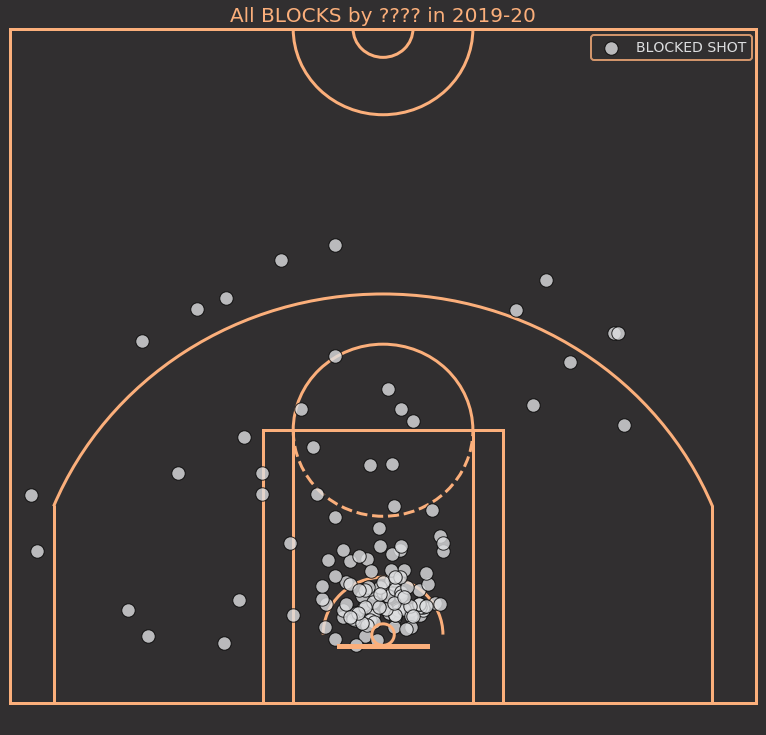

In [33]:
plot_raw_shotchart(data_frame=player_blocks, title="All BLOCKS by ???? in 2019-20", mode='dark')

## Ayton

In [41]:
player_id = find_players_by_full_name('Myles Turner')[0]['id']

In [42]:
team_id = find_teams_by_full_name('Indiana Pacers')[0]['id']

In [43]:
pbp_df, stats_dfs, data_dfs = get_pbp_dfs(player_id=player_id, team_id=team_id)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [02:55<00:00,  3.19s/it]


In [44]:
pbp_df.locX = -pbp_df.locX

In [45]:
player_blocks = pbp_df.loc[((pbp_df.PLAYER2_ID == player_id) | (pbp_df.PLAYER3_ID == player_id)) & ((pbp_df.HOMEDESCRIPTION.str.contains('BLK', na=False)) | (pbp_df.VISITORDESCRIPTION.str.contains('BLK', na=False)))]

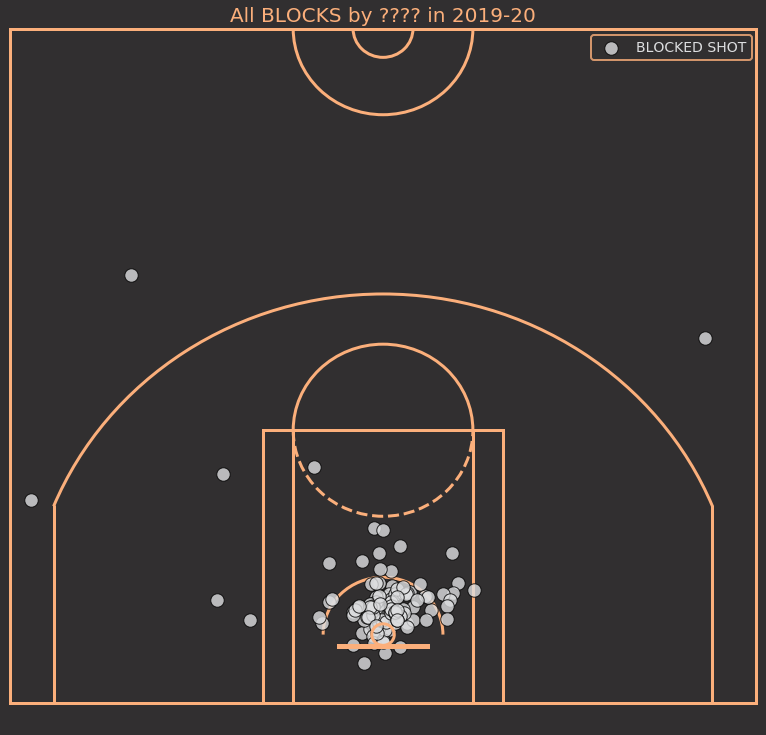

In [46]:
plot_raw_shotchart(data_frame=player_blocks, title="All BLOCKS by ???? in 2019-20", mode='dark')